
# Simple example of two-session fMRI model fitting

Here, we will go through a full step-by-step example of fitting a :term:`GLM`
to experimental data and visualizing the results.
This is done on two runs of one subject of the FIAC dataset.

For details on the data, please see:

Dehaene-Lambertz G, Dehaene S, Anton JL, Campagne A, Ciuciu P, Dehaene
G, Denghien I, Jobert A, LeBihan D, Sigman M, Pallier C, Poline
JB. Functional segregation of cortical language areas by sentence
repetition. Hum Brain Mapp. 2006: 27:360--371.
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6871319/

More specifically:

1. A sequence of :term:`fMRI` volumes is loaded.
2. A design matrix describing all the effects related to the data is computed.
3. A mask of the useful brain volume is computed.
4. A :term:`GLM` is applied to the dataset (effect/covariance,
   then contrast estimation).

Technically, this example shows how to handle two sessions that contain the
same experimental conditions. The model directly returns a fixed effect of the
statistics across the two sessions.


Create a write directory to work,
it will be a 'results' subdirectory of the current directory.



In [1]:
from os import getcwd, mkdir, path

write_dir = path.join(getcwd(), 'results')
if not path.exists(write_dir):
    mkdir(write_dir)

## Prepare data and analysis parameters

Note that there are two sessions.



In [ ]:
from nilearn.datasets import func

data = func.fetch_fiac_first_level()
fmri_img = [data['func1'], data['func2']]

In [17]:
from nilearn.image import load_img, math_img

tmp=load_img(fmri_img[0])
tmp.header.get_zooms()

(3.0000024, 3.0000038, 4.0, 1.0)

Create a mean image for plotting purpose.



In [3]:
from nilearn.image import mean_img

mean_img_ = mean_img(fmri_img[0])

The design matrices were pre-computed, we simply put them in a list of
DataFrames.



In [4]:
import numpy as np
import pandas as pd

design_files = [data['design_matrix1'], data['design_matrix2']]
design_matrices = [pd.DataFrame(np.load(df)['X']) for df in design_files]

In [20]:
design_matrices[0].di


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.180236e-14,-7.781773e-14,2.827377e-14,7.678016e-14,5.187849e-15,6.488857,6.488637,6.487979,6.486882,6.485346,6.483372,6.480959,6.478107
1,-8.559950e-15,-7.055474e-14,-1.400719e-14,6.847960e-14,1.099824e-13,6.488857,6.487364,6.482886,6.475424,6.464983,6.451567,6.435182,6.415836
2,-2.879256e-14,-6.640446e-14,1.010334e-13,5.758512e-14,5.162890e+00,6.488857,6.483325,6.466740,6.439130,6.400542,6.351042,6.290713,6.219659
3,-3.346162e-14,-3.994643e-14,3.011469e-01,5.583422e-14,2.684270e+01,6.488857,6.479215,6.450318,6.402252,6.335159,6.249240,6.144748,6.021996
4,5.187849e-15,-2.412350e-14,2.474755e+01,7.444563e-14,2.482296e+01,6.488857,6.470924,6.417224,6.328055,6.203909,6.045472,5.853619,5.629413
...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,-1.028194e-06,-1.924004e+01,-2.536980e-14,-7.336089e-14,-1.745941e-02,6.488857,-6.477978,6.445377,-6.391163,6.315519,-6.218698,6.101024,-5.962893
187,-2.023353e-07,-1.945026e+01,-4.850081e-14,-5.610337e-14,-4.555051e-03,6.488857,-6.482379,6.462959,-6.430634,6.385470,-6.327558,6.257011,-6.173972
188,-1.678181e-08,-9.688080e+00,-2.436652e-14,-7.011521e-14,-5.444394e-04,6.488857,-6.486854,6.480847,-6.470840,6.456839,-6.438852,6.416891,-6.390969
189,-3.095373e-09,-4.606665e+00,-9.515953e-15,-7.169034e-14,-1.241630e-04,6.488857,-6.488419,6.487105,-6.484916,6.481852,-6.477913,6.473099,-6.467412


## :term:`GLM` estimation
:term:`GLM` specification. Note that the mask was provided in the dataset.
So we use it.



In [5]:
from nilearn.glm.first_level import FirstLevelModel

fmri_glm = FirstLevelModel(mask_img=data['mask'], minimize_memory=True)

Let's fit the GLM.



In [6]:
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=design_matrices)

Compute fixed effects of the two runs and compute related images.
For this, we first define the contrasts as we would do for a single session.



In [21]:
n_columns = design_matrices[0].shape[1]
print(n_columns)

def pad_vector(contrast_, n_columns):
    """Append zeros in contrast vectors."""
    return np.hstack((contrast_, np.zeros(n_columns - len(contrast_))))

13


Contrast specification



In [8]:
contrasts = {'SStSSp_minus_DStDSp': pad_vector([1, 0, 0, -1], n_columns),
             'DStDSp_minus_SStSSp': pad_vector([-1, 0, 0, 1], n_columns),
             'DSt_minus_SSt': pad_vector([-1, -1, 1, 1], n_columns),
             'DSp_minus_SSp': pad_vector([-1, 1, -1, 1], n_columns),
             'DSt_minus_SSt_for_DSp': pad_vector([0, -1, 0, 1], n_columns),
             'DSp_minus_SSp_for_DSt': pad_vector([0, 0, -1, 1], n_columns),
             'Deactivation': pad_vector([-1, -1, -1, -1, 4], n_columns),
             'Effects_of_interest': np.eye(n_columns)[:5]}

Next, we compute and plot the statistics.



In [9]:
from nilearn import plotting

print('Computing contrasts...')
for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
    print(f"  Contrast {index + 1: 2} out of {len(contrasts)}: {contrast_id}")
    # Estimate the contasts. Note that the model implicitly computes a fixed
    # effect across the two sessions
    z_map = fmri_glm.compute_contrast(
        contrast_val, output_type='z_score')

    # write the resulting stat images to file
    z_image_path = path.join(write_dir, f'{contrast_id}_z_map.nii.gz')
    z_map.to_filename(z_image_path)

Computing contrasts...
  Contrast  1 out of 8: SStSSp_minus_DStDSp
  Contrast  2 out of 8: DStDSp_minus_SStSSp


/projectnb/viscog01/venvs/wen_env/bin/python/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 2 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")


  Contrast  3 out of 8: DSt_minus_SSt
  Contrast  4 out of 8: DSp_minus_SSp
  Contrast  5 out of 8: DSt_minus_SSt_for_DSp
  Contrast  6 out of 8: DSp_minus_SSp_for_DSt
  Contrast  7 out of 8: Deactivation
  Contrast  8 out of 8: Effects_of_interest


/projectnb/viscog01/venvs/wen_env/bin/python/lib/python3.10/site-packages/nilearn/glm/contrasts.py:381: UserWarning: Running approximate fixed effects on F statistics.
  warn("Running approximate fixed effects on F statistics.")


We can then compare session-specific and fixed effects.
Here, we compare the activation mas produced from each session separately and
then the fixed effects version.



In [10]:
contrast_id = 'Effects_of_interest'

Compute the statistics for the first session.



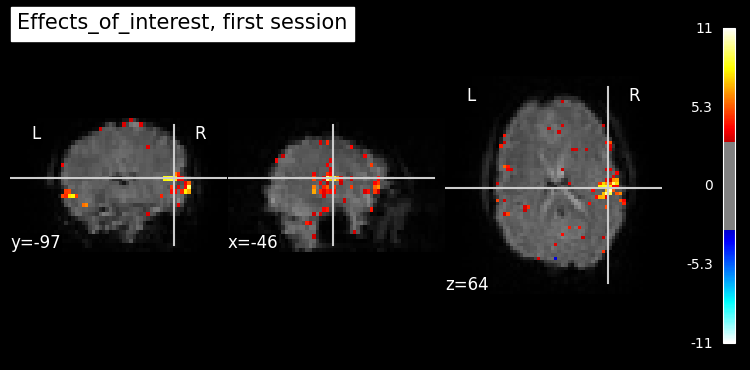

In [11]:
fmri_glm = fmri_glm.fit(fmri_img[0], design_matrices=design_matrices[0])
z_map = fmri_glm.compute_contrast(
    contrasts[contrast_id], output_type='z_score')
plotting.plot_stat_map(
    z_map, bg_img=mean_img_, threshold=3.0,
    title=f'{contrast_id}, first session')

Compute the statistics for the second session.



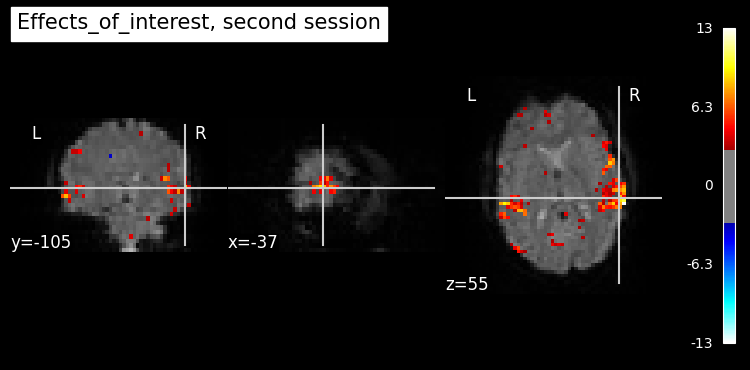

In [12]:
fmri_glm = fmri_glm.fit(fmri_img[1], design_matrices=design_matrices[1])
z_map = fmri_glm.compute_contrast(
    contrasts[contrast_id], output_type='z_score')
plotting.plot_stat_map(
    z_map, bg_img=mean_img_, threshold=3.0,
    title=f'{contrast_id}, second session')

Compute the Fixed effects statistics.



/projectnb/viscog01/venvs/wen_env/bin/python/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 2 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")
/projectnb/viscog01/venvs/wen_env/bin/python/lib/python3.10/site-packages/nilearn/glm/contrasts.py:381: UserWarning: Running approximate fixed effects on F statistics.
  warn("Running approximate fixed effects on F statistics.")


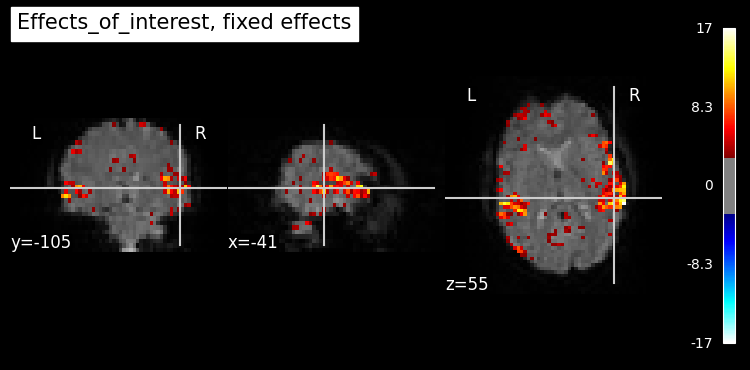

In [13]:
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=design_matrices)
z_map = fmri_glm.compute_contrast(
    contrasts[contrast_id], output_type='z_score')
plotting.plot_stat_map(
    z_map, bg_img=mean_img_, threshold=3.0,
    title=f'{contrast_id}, fixed effects')

plotting.show()

Not unexpectedly, the fixed effects version displays higher peaks than the
input sessions. Computing fixed effects enhances the signal-to-noise ratio of
the resulting brain maps.



## Generating a report
Since we have already computed the FirstLevelModel and
and have the contrast, we can quickly create a summary report.



In [14]:
from nilearn.reporting import make_glm_report

report = make_glm_report(fmri_glm,
                         contrasts,
                         bg_img=mean_img_,
                         )

/projectnb/viscog01/venvs/wen_env/bin/python/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 2 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")
/projectnb/viscog01/venvs/wen_env/bin/python/lib/python3.10/site-packages/nilearn/glm/contrasts.py:381: UserWarning: Running approximate fixed effects on F statistics.
  warn("Running approximate fixed effects on F statistics.")


We have several ways to access the report:



In [15]:
# report  # This report can be viewed in a notebook
# report.save_as_html('report.html')
# report.open_in_browser()